# Lekce 12

In [1]:
import pandas
import requests
import numpy


from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    accuracy_score,
)

## Co to je NLP
Práce s přirozeným jazykem je odlišná od práce s jinými daty, a proto si zaslouží vlastní skupinu technik a algoritmů - NLP (Natural Language Processing). Ne všechny úlohy NLP se musí řešit pomocí strojového učení, ale v dnešní době tomu tak většinou je. Příklady úloh, které spadají do NLP jsou například:

- Strojový překlad (text v angličtině => text v češtině)
- Rozpoznávání řeči (řeč v češtině => text v češtině)
- Syntéza řeči (text v češtině > řeč v češtině)
- Klasifikace textu

Tyto úlohy určitě znáte i z běžného života. Další úlohy, které řeší NLP, a nacházejí se často "pod kapotou" jiných systémů, jsou například:

- Rozpoznávání pojmenovaných entit (NER, Named Entity Recognition): Pojmenované entity jsou výrazy, které označují jména, místa, data, názvy, ... Jaké pojmenované entity bychom mohli označit například ve větě _Král Karel si v Londýně včera zašel do kavárny Starbucks._ ?
- Určování slovních druhů (POS tagging, Part-of-speech tagging)
- Zjednodušení textu, shrnutí textu
- Určení významu slova (WSD, Word Sense Disambiguation): Při dvou významech slova _kolej_ (studentské ubytování, železniční dráha), který z nich je zachycený větou _Včera proběhl na koleji večírek._ ?

### Reprezentace textových dat

Naše datasety doposud obsahovaly proměnné, a datové body (pozorování) reprezentované pomocí těchto proměnných. Například u vzorku vody jsme dostali proměnné na základě chemického rozboru. U textových dat většinou dostaneme syrovější podobu dat, nikoliv proměnné. Jako kdybychom dostali vzorky vody, a sami museli provést chemickou analýzu.

Obecně řečeno, i v případě textu budeme jednotlivá pozorování nebo datové body reprezentovat pomocí číselných hodnot vstupních proměnných. Co ale budou tyto proměnné, označené v obrázku jako barvy, reprezentovat?

K reprezentování dat můžeme využít `CountVectorizer`. Ten vytvoří matici, kde každé slovo je reprezentováno jedním sloupcem a každý text ve vstupních datech jedním řádkem. Jeho fungování si nejprve ukážeme na jednoduchých datech, kde 4 uživatelé a uživatelky diskusního fóra vyjádřili své názory na jazyk Python. Celkem máme 4 diskusní příspěvky. Naším úkolem by bylo provést analýzu textu, která zjistí, kolik uživatelů (uživatelek) má k Pythonu kladný vztah a kolik záporný. Tento typ úloh je často označován jako analýza sentimentu (*sentiment analysis*).

Níže vidíme pole, které má 8 sloupců (v datech je totiž 8 unikátních slov) a 4 řádky (v datech jsou 4 řetězce). Pomocí metody `vec.get_feature_names_out()` si můžeme zobrazit popisky sloupců.

In [2]:
X = ["Python is great", "I like Python", "Python is the best language", "I hate Python"]
vec = CountVectorizer()
X = vec.fit_transform(X)
X = X.toarray()
X

array([[0, 1, 0, 1, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1, 1, 0],
       [1, 0, 0, 1, 1, 0, 1, 1],
       [0, 0, 1, 0, 0, 0, 1, 0]])

In [3]:
vec.get_feature_names_out()

array(['best', 'great', 'hate', 'is', 'language', 'like', 'python', 'the'],
      dtype=object)

Pro větší přehlednost si můžeme převést data do pandas tabulky. Vidíme například, že slovo `great` má hodnotu `1` pro řádek `0` (dokument na nulté pozici při počítání od 0). V datech vidíme, že slovo `great` se v něm skutečně vyskytuje. Ve všech ostatních příspěvcích se toto slovo nevyskytuje, proto mají ostatní řádky v tom sloupci hodnotu `0`.

In [4]:
df = pandas.DataFrame(X, columns=vec.get_feature_names_out())
df

,best,great,hate,is,language,like,python,the
0,0,1,0,1,0,0,1,0
1,0,0,0,0,0,1,1,0
2,1,0,0,1,1,0,1,1
3,0,0,1,0,0,0,1,0


Pokud se na slova podíváme, dokázali bychom je rozdělit na několik skupin:

- slova, která naznačují kladný vztah (best, great, v tomto případě i slovo like, ale u něj to tak nemusí být vždy),
- slova, která naznačují negativní vztah (hate),
- slova, která nenaznačují ani jedno (is, language, python, the).

Obecně bychom pak mohli říci, že vysoký počet "pozitivní slov" vede spíše k tomu, že celý komentář je zamýšlen pozitivně, a vysoký počet "negativních slov" vede k tomu, že celý komentář je negativní. Tento postup určitě není dokonalý (např. nerozpozná sarkasmus), ale umožní nám využít algoritmy, které už známe.

Uvažujme dále, že v jazyce je obrovské množství slov a my je nechceme ručně třídit. Na internetu ale můžeme najít datové sady, které obsahují nějaký text a k tomu označení, zda je text celkově pozitivní nebo negativní. Například u recenzí často lidé vyplňují textový komentář i hodnocení na nějaké škále (např. 1 až 5 hvězd). Můžeme pak použít supervised learning (učení s učitelem) a "ohodnotit" jednotlivá slova (nebo skupiny slov) jako pozitivní nebo negativní.

Analýza sentimentu ale není jediná úloha, která funguje na tomto principu. Obecně můžeme třídit dokumenty do skupin například v systémech uživatelské podpory (stěžuje si uživatel na problémy s internetem, chce levnější tarif, chce si aktivovat roaming?), při třídění článků do rubrik atd.

Pojďme si nyní načíst dataset, se [kterým budeme dneska pracovat](movies.csv). Jedná se o databázi popisů filmů ze serveru IMDB. K dispozici máme název filmu, jeho žánr (to bude naše výstupní proměnná), a text popisku filmu. Text popisku budeme chtít převést na naše vstupní proměnné. Pokud bychom dobře ohodnotili jednotlivé slova, můžeme pak podle jejich počtu v dokumentu odhadnout, jaké je celkové vyznění zprávy.

Naším úkolem bude odhadnout žánr filmu, ke kterému popis patří. V datech máme název filmu, žánr a textový popis. Naším úkolem bude vytvořit model, který dokáže zařadit film do žánru, i když oficiální informaci od tvůrců filmu nemáme.

In [5]:
data = pandas.read_csv("movies.csv")
data.head()

,title,genre,text
0,Santa Barbara (2014),romance,"Because of his close friend's betrayal, music ..."
1,Behen Hogi Teri (2017),comedy,"Gattu (Rajkummar Rao) has a problem, he loves ..."
2,The Last Coffin (2003),horror,"In the movie, a strange crossword puzzle start..."
3,Lady Krampus (2016),horror,"It's Christmas time in Cleveland, Ohio and fou..."
4,"""Pandemic"" (2016)",thriller,A deadly virus is unleashed on the fictional n...


Rozdělíme data na vstupní a výstupní proměnnou a poté na trénovací a testovací data.

In [6]:
X = data["text"]
y = data["genre"]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

Musíme myslet na to, že rozložení jednotlivých skupin je velmi nerovnoměrné, například komedií je mnohem více než sci-fi filmů.

<Axes: xlabel='genre'>

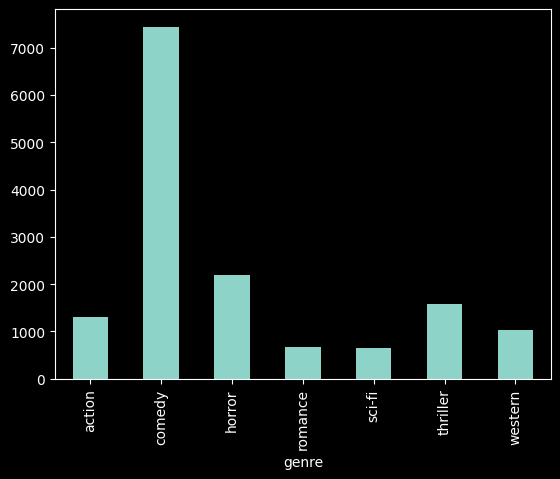

In [7]:
data.groupby("genre").size().plot(kind="bar")

Jako první formu reprezentace popisků vyzkoušíme jednotlivá slova a jejich počty. V podstatě vytvoříme slovní zásobu, která bude obsahovat všechna slova, co se v našich trénovacích datech objeví. Jedno slovo bude jedna proměnná a hodnota proměnné bude počet, kolikrát se slovo v dokumentu (zde popisku filmu) objeví. Opět použijeme `CountVectorizer`.

In [8]:
vec = CountVectorizer()
X_train = vec.fit_transform(X_train)
X_test = vec.transform(X_test)

Jak teď naše data vypadají?

In [9]:
X_train.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

Podívejme se na rozměry tabulky.

In [10]:
X_train.toarray().shape

(11181, 49445)

In [11]:
vec.get_feature_names_out()

array(['00', '000', '003', ..., 'ťthe', 'źs', 'žš'], dtype=object)

Vidíme, že data mají cca 49 tisíc unikátních slov. Bylo by pro nás jako pro lidi opravdu příliš pracné tato slova ručně projít a rozdělit na skupiny, jako jsme to provedli u imaginárních dat s hodnoceními jazyka Python. Můžeme ale využít některý z algoritmů supervised learning. Ten zařadí film do žánru v závislosti na tom, do jakých žánrů patří filmy s popisy, které obsahuje podobná slova.

Pojďme tedy zkusit tyto vstupní proměnné předat klasifikačnímu algoritmu K Nearest Neighbours. Uvažujme například 5 nejbližších sousedů, tj. výchozí hodnotu.

In [12]:
clf = KNeighborsClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

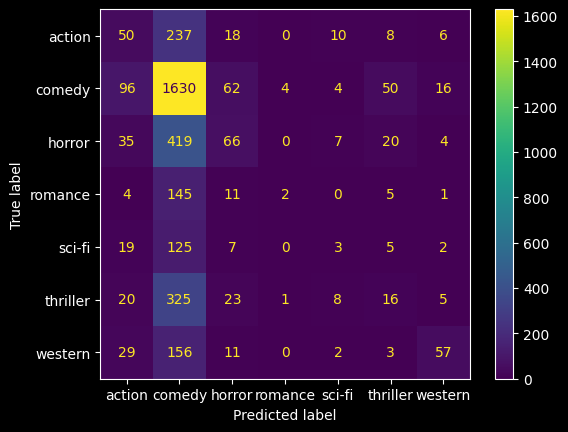

In [13]:
ConfusionMatrixDisplay.from_estimator(
    clf,
    X_test,
    y_test,
)

In [14]:
accuracy_score(y_test, y_pred)

0.48940166353635634

Jak můžeme úspěšnost modelu zlepšit? V podstatě jsou dvě úrovně: Úroveň dat, a úroveň klasifikačního algoritmu. Pojďme začít u dat, protože když nebudeme mít čistá data, žádný algoritmus nás nezachrání (toto se dá také shrnout pořekadlem "garbage in, garbage out").

- Všimněme si, že nejčastější slova jsou taková, která se nacházejí skoro ve všech popiskách. Těmto častým slovům, která nenesou žádný význam, se říka _stop words_. Každý jazyk má svůj blacklist těchto slov, která se většinou z dat úplně vyfiltrují. `CountVectorizer` má parametr `stop_words`, který můžeme nastavit na hodnotu `"english"`. 

- Dále se zamysleme nad tím, co znamenají hodnoty našich vstupních proměnných. Možná by bylo lepší tyto hodnoty nějak normalizovat (co kdybychom například měli veliké rozdíly mezi délkou vstupních dokumentů?). Populární metoda pro normalizaci četností slov je TF-IDF (Term Frequency Inverse Document Frequency). Tato normalizace zohledňuje jak četnost slova v dokumentu, tak i to, jak často se objevuje vůbec v celých vstupních datech. Takže slovo, které by se velmi často objevovalo jen v několika dokumentech, by mělo větší váhu, než jiné slovo, které se objevuje v mnoha dokumentech. 

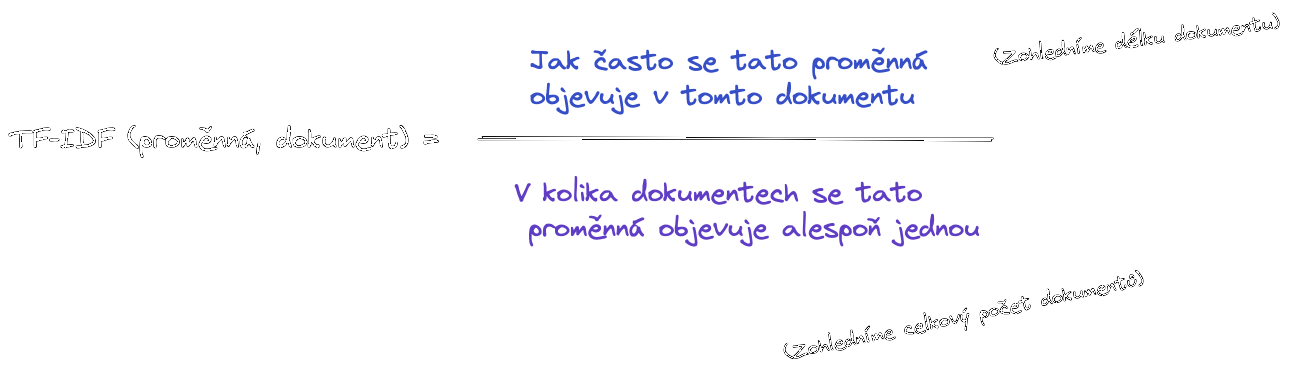

Můžeme tedy `CountVectorizer` vyměnit za `TfidfVectorizer`. Jak moc je teď důležitý parametr `stop_words`?

In [15]:
X = ["Python is great", "I like Python", "Python is the best language", "I hate Python"]
vec = TfidfVectorizer()
X = vec.fit_transform(X)
X = X.toarray()
X

array([[0.        , 0.72664149, 0.        , 0.5728925 , 0.        ,
        0.        , 0.37919167, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.88654763, 0.46263733, 0.        ],
       [0.50676543, 0.        , 0.        , 0.39953968, 0.50676543,
        0.        , 0.26445122, 0.50676543],
       [0.        , 0.        , 0.88654763, 0.        , 0.        ,
        0.        , 0.46263733, 0.        ]])

In [16]:
vec.get_feature_names_out()

array(['best', 'great', 'hate', 'is', 'language', 'like', 'python', 'the'],
      dtype=object)

In [17]:
df = pandas.DataFrame(X, columns=vec.get_feature_names_out())
df

,best,great,hate,is,language,like,python,the
0,0.000000,0.726641,0.000000,0.572892,0.000000,0.000000,0.379192,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.886548,0.462637,0.000000
2,0.506765,0.000000,0.000000,0.399540,0.506765,0.000000,0.264451,0.506765
3,0.000000,0.000000,0.886548,0.000000,0.000000,0.000000,0.462637,0.000000


Nyní zkusíme přidat parametr `stop_words`. Která slova nám z dat zmizela?

In [18]:
X = ["Python is great", "I like Python", "Python is the best language", "I hate Python"]
vec = TfidfVectorizer(stop_words="english")
X = vec.fit_transform(X)
X = X.toarray()
X

array([[0.        , 0.88654763, 0.        , 0.        , 0.        ,
        0.46263733],
       [0.        , 0.        , 0.        , 0.        , 0.88654763,
        0.46263733],
       [0.66338461, 0.        , 0.        , 0.66338461, 0.        ,
        0.34618161],
       [0.        , 0.        , 0.88654763, 0.        , 0.        ,
        0.46263733]])

In [19]:
vec.get_feature_names_out()

array(['best', 'great', 'hate', 'language', 'like', 'python'],
      dtype=object)

In [20]:
df = pandas.DataFrame(X, columns=vec.get_feature_names_out())
df

,best,great,hate,language,like,python
0,0.000000,0.886548,0.000000,0.000000,0.000000,0.462637
1,0.000000,0.000000,0.000000,0.000000,0.886548,0.462637
2,0.663385,0.000000,0.000000,0.663385,0.000000,0.346182
3,0.000000,0.000000,0.886548,0.000000,0.000000,0.462637


### Čtení na doma - postup výpočtu

Podívejme se na způsob výpočtu. Vraťme se k tabulce, kterou vygeneruje `CountVectorizer`.

In [21]:
X = ["Python is great", "I like Python", "Python is the best language", "I hate Python"]

vec = CountVectorizer(stop_words="english")
X = vec.fit_transform(X)
X = X.toarray()
X

array([[0, 1, 0, 0, 0, 1],
       [0, 0, 0, 0, 1, 1],
       [1, 0, 0, 1, 0, 1],
       [0, 0, 1, 0, 0, 1]])

Nyní porovnejme matici s tím, co vygeneruje `TfidfVectorizer`. Dále přibyl parametr `smooth_idf`, jehož funkci si ještě objasníme.

In [22]:
X = ["Python is great", "I like Python", "Python is the best language", "I hate Python"]

vec = TfidfVectorizer(stop_words="english", smooth_idf=False)
X = vec.fit_transform(X)
X = X.toarray()
X

array([[0.        , 0.9222914 , 0.        , 0.        , 0.        ,
        0.38649524],
       [0.        , 0.        , 0.        , 0.        , 0.9222914 ,
        0.38649524],
       [0.67796827, 0.        , 0.        , 0.67796827, 0.        ,
        0.28410924],
       [0.        , 0.        , 0.9222914 , 0.        , 0.        ,
        0.38649524]])

In [23]:
vec.get_feature_names_out()

array(['best', 'great', 'hate', 'language', 'like', 'python'],
      dtype=object)

Pro přehlednost si zobrazíme výsledek jako pandas tabulku (`DataFrame`).

In [24]:
df = pandas.DataFrame(X, columns=vec.get_feature_names_out())
df

,best,great,hate,language,like,python
0,0.000000,0.922291,0.000000,0.000000,0.000000,0.386495
1,0.000000,0.000000,0.000000,0.000000,0.922291,0.386495
2,0.677968,0.000000,0.000000,0.677968,0.000000,0.284109
3,0.000000,0.000000,0.922291,0.000000,0.000000,0.386495


Vypočítejme si nyní sami hodnoty v tabulce pro první řádek, abychom pochopili, jak `TfidfVectorizer` funguje. Začneme s výrazem great. Postupujeme podle vzorce.

$$
\textrm{idf}(t) = \log \frac{n}{1 + \textrm{df}(t)}
$$

kde $\textrm{df}$ je počlet dokumentů, které obsahují výraz $t$, $n$ je celkový počet dokumentů a výsledkem je $idf$ (inverse document-frequency).

In [25]:
n = 4
df_great = 1
idf_great = numpy.log(n / df_great) + 1
idf_great

2.386294361119891

Dále dopočítáme hodnotu ukazatel tf-idf s využitím vzorce

$$
\textrm{tf-idf}(t,d) = \textrm{tf}(t,d) * \textrm{tf}
$$

kde $\textrm{tf}(t,d)$ znamená term-frequency, tj. počet výskytů výrazu $t$, který vidíme v tabulce, kterou nám vygeneroval `CountVectorizer`.

In [26]:
tf_idf_great = 1 * idf_great
tf_idf_great

2.386294361119891

Nyní postupujeme stejně pro výraz Python. Ten se objevuje ve všech 4 dokumentech.

In [27]:
df_python = 4
idf_python = numpy.log(n / df_python) + 1
idf_python

1.0

In [28]:
tf_idf_python = 1 * idf_python
tf_idf_python

1.0

Nakonec provedeme normalizaci, kterou získáme jako podíl tf-idf pro dané slovo a odmocninu druhých mocnin tf-idf pro všechna slova. Níže vidíme, že výsledek odpovídá hodnotě pro výraz great v dokumentu 0.

In [29]:
tf_idf_great / numpy.sqrt(tf_idf_great**2 + tf_idf_python**2)

0.92229140312174

Dále si vyzkoušíme variantu bez parametru `smooth_idf`.

In [30]:
X = ["Python is great", "I like Python", "Python is the best language", "I hate Python"]

vec = TfidfVectorizer(stop_words="english")
X = vec.fit_transform(X)
X = X.toarray()
X

array([[0.        , 0.88654763, 0.        , 0.        , 0.        ,
        0.46263733],
       [0.        , 0.        , 0.        , 0.        , 0.88654763,
        0.46263733],
       [0.66338461, 0.        , 0.        , 0.66338461, 0.        ,
        0.34618161],
       [0.        , 0.        , 0.88654763, 0.        , 0.        ,
        0.46263733]])

In [31]:
df = pandas.DataFrame(X, columns=vec.get_feature_names_out())
df

,best,great,hate,language,like,python
0,0.000000,0.886548,0.000000,0.000000,0.000000,0.462637
1,0.000000,0.000000,0.000000,0.000000,0.886548,0.462637
2,0.663385,0.000000,0.000000,0.663385,0.000000,0.346182
3,0.000000,0.000000,0.886548,0.000000,0.000000,0.462637


Rozdíl je v tom, že idf počítáme z mírně upraveného vzorce

$$
\textrm{idf}(t) = \log \frac{1 + n}{1 + \textrm{df}(t)} + 1
$$

In [32]:
n = 4
df_great = 1
idf_great = numpy.log((1 + n) / (1 + df_great)) + 1
tf_idf_great = 1 * idf_great
df_python = 4
idf_python = numpy.log((1 + n) / (1 + df_python)) + 1
tf_idf_python = 1 * idf_python
tf_idf_great / numpy.sqrt(tf_idf_great**2 + tf_idf_python**2)

0.8865476297873808

### Vlastní seznam stop words

Pokud nám nevyhovuje výchozí seznam stop words pro daný jazyk, můžeme si vytvořit svůj. To se může hodit pro češtinu nebo třeba v situaci, že se dané slovo vyskytuje často (např. v příspěvcích o Pythonu se bude často opakovat slovo Python).

In [33]:
X = [
    "Python je nejlepší",
    "Mám rád Python!",
    "Python je nejlepší jazyk",
    "Nesnáším Python!",
]
vec = TfidfVectorizer(stop_words=["je", "mám", "Python"])
X = vec.fit_transform(X)
X = X.toarray()
X

/Users/entiaperse/Library/Python/3.9/lib/python/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['python'] not in stop_words.
  warnings.warn(


array([[0.        , 0.83388421, 0.        , 0.55193942, 0.        ],
       [0.        , 0.        , 0.        , 0.46263733, 0.88654763],
       [0.72664149, 0.5728925 , 0.        , 0.37919167, 0.        ],
       [0.        , 0.        , 0.88654763, 0.46263733, 0.        ]])

In [34]:
vec.get_feature_names_out()

array(['jazyk', 'nejlepší', 'nesnáším', 'python', 'rád'], dtype=object)

In [35]:
df = pandas.DataFrame(X, columns=vec.get_feature_names_out())
df

,jazyk,nejlepší,nesnáším,python,rád
0,0.000000,0.833884,0.000000,0.551939,0.000000
1,0.000000,0.000000,0.000000,0.462637,0.886548
2,0.726641,0.572892,0.000000,0.379192,0.000000
3,0.000000,0.000000,0.886548,0.462637,0.000000


### Klasifikace dokumentů

Vyzoušejme nyní klasifikaci dokumentů (resp. filmů, o kterých dané dokumenty pojednávají). Využít můžeme například algoritmus `KNeighborsClassifier`.

In [36]:
X = data["text"]
y = data["genre"]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

vec = TfidfVectorizer()
X_train = vec.fit_transform(X_train)
X_test = vec.transform(X_test)

clf = KNeighborsClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

accuracy_score(y_test, y_pred)

0.5709686074590824

Porovnáme accuracy s výsledkem stejného algoritmu při využití parametru `stop_words`.

In [37]:
X = data["text"]
y = data["genre"]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

# Uvažujeme stop_words v angličtině
vec = TfidfVectorizer(stop_words="english")
X_train = vec.fit_transform(X_train)
X_test = vec.transform(X_test)

clf = KNeighborsClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

accuracy_score(y_test, y_pred)

0.5811644754494232

Níže si zobrazíme matici záměn. Vidíme například, že náš model označil 228 hororů za komedii a naopak 108 komedií za horor.

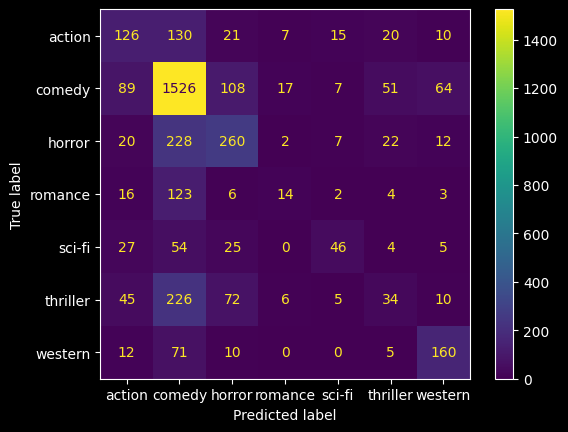

In [38]:
ConfusionMatrixDisplay.from_estimator(
    clf,
    X_test,
    y_test,
)

Zkusme nyní přidat i dvojice slov. K tomu slouží parametr `ngram_range`.

In [39]:
X = data["text"]
y = data["genre"]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

# Uvažujeme stop words v angličtině, samostatná slova a dvojice slov
vec = TfidfVectorizer(stop_words="english", ngram_range=(1, 2))
X_train = vec.fit_transform(X_train)
X_test = vec.transform(X_test)

clf = KNeighborsClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

accuracy_score(y_test, y_pred)

0.594311778910652

Dále můžeme využít i lineární verzi algoritmu Support Vector Machine. Ten očividně dosahuje výrazně lepších výsledků.

In [40]:
X = data["text"]
y = data["genre"]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

vec = TfidfVectorizer(stop_words="english", ngram_range=(1, 2))
X_train = vec.fit_transform(X_train)
X_test = vec.transform(X_test)

clf = LinearSVC()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

accuracy_score(y_test, y_pred)

0.7646900992755568

Zjistit můžeme seznam skupin, na které algoritmus třídí popisy (to jsou žárny filmů, které uvažujeme).

In [41]:
clf.classes_

array(['action', 'comedy', 'horror', 'romance', 'sci-fi', 'thriller',
       'western'], dtype=object)

Pro každé slovo a každý žánr vygeneruje algoritmus SVM koeficient. Čím je koeficient vyšší, patří spíše koeficient k danému žánru.

In [42]:
df_coef = pandas.DataFrame(clf.coef_.T, columns=clf.classes_)
df_coef["words"] = vec.get_feature_names_out()
df_coef = df_coef.set_index("words")
df_coef

,action,comedy,horror,romance,sci-fi,thriller,western
words,,,,,,,
00,-0.099350,0.130305,0.120463,-1.507127e-02,-0.026517,-0.073392,-0.018794
00 31,-0.012009,-0.115527,0.140133,0.000000e+00,-0.014201,0.000000,0.000000
00 bonus,-0.001865,0.017467,0.000000,-3.823530e-03,0.000000,-0.009323,-0.003264
00 breast,-0.001865,0.017467,0.000000,-3.823530e-03,0.000000,-0.009323,-0.003264
00 cameraman,-0.000086,-0.094925,0.120942,-2.710505e-20,-0.004197,-0.019086,0.000000
...,...,...,...,...,...,...,...
źs,-0.037891,0.166505,-0.055953,-3.898884e-03,-0.018278,-0.033222,0.000000
źs 70,-0.018945,0.083252,-0.027976,-1.949442e-03,-0.009139,-0.016611,0.000000
źs sit,-0.018945,0.083252,-0.027976,-1.949442e-03,-0.009139,-0.016611,0.000000


Můžeme si to vyzkoušet na žánru sci-fi. Níže jsou slova, která jsou typická pro sci-fi (mají nejvyšší hodnoty koeficientů).

In [43]:
df_coef.sort_values("sci-fi", ascending=False).head(20)

,action,comedy,horror,romance,sci-fi,thriller,western
words,,,,,,,
earth,-0.294948,-1.237952,-0.801129,-0.268357,3.309363,-0.806987,-0.353077
alien,-0.566869,-1.197390,-0.757693,-0.077991,2.773563,-0.334576,-0.112049
space,-0.768361,-0.964672,-0.311594,-0.133083,2.477230,-0.393163,-0.192474
planet,0.009480,-1.036256,-0.557429,-0.187358,2.372878,-0.624937,-0.270642
future,0.057929,-1.028436,-0.682450,0.173209,1.988740,-0.305909,-0.325943
scientist,-0.221591,-0.927773,0.184160,-0.110859,1.536081,-0.304290,-0.161322
humans,0.000865,-0.684499,-0.462961,-0.162125,1.530960,-0.128611,-0.097184
fi,-0.249849,-0.797507,-0.137050,0.016366,1.432206,-0.296492,-0.099476
universe,0.071515,-0.684298,-0.239304,-0.069726,1.418393,-0.461758,-0.137468


Níže jsou slova, která která jsou typická pro jiné žárny než pro sci-fi (mají nejnižší hodnoty koeficientů).

In [44]:
df_coef.sort_values("sci-fi", ascending=False).tail(20)

,action,comedy,horror,romance,sci-fi,thriller,western
words,,,,,,,
vampire,-0.688379,-1.086779e+00,2.751205,-0.093724,-0.378507,-0.610544,-0.218636
better,0.005629,9.727023e-01,0.039949,-0.250133,-0.378783,-0.404199,-0.107159
face,0.235859,-7.031105e-01,0.311122,0.189370,-0.382372,0.272669,-0.020216
brother,0.345755,-9.504231e-01,0.153662,0.079176,-0.383114,0.112089,0.684899
gets,-0.137309,5.323844e-01,-0.851606,0.097244,-0.389205,0.335903,0.259116
house,-1.068138,-6.578624e-01,2.113204,-0.307470,-0.395766,0.115149,-0.808791
girlfriend,-0.256424,8.704555e-01,0.047938,-0.116427,-0.411818,0.034272,-0.454765
decide,-0.180514,7.390595e-01,0.228444,-0.032534,-0.427470,-0.425363,-0.201886
orbot,0.368715,2.602085e-18,0.000000,0.000000,-0.436092,0.000000,0.000000
